## Ensayos usando la libreria libEMG

## Sobre la libreria

* **Paper**: LibEMG: An Open Source Library to Facilitate the Exploration of Myoelectric Control ([link](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10214558))
* **Repo**: https://github.com/LibEMG/libemg

Modulos: 
1. Data Handling
2. Filtering
3. Feature Extraction
4. Feature Selection
5. Classification
6. Evaluation

En teoria la libreria se logro instalar con exito.

Instalar para evitar warnings

```
pip install --upgrade paramiko
pip install --upgrade cryptography
```

Con eso ya no salen las advertencias.

In [9]:
try:
    import libemg
    print("La librería 'libEMG' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'libEMG' no está instalada.")

La librería 'libEMG' está instalada y se ha importado correctamente.


Se importa el dataset a analizar mediante el OfflineDataHandler.

In [2]:
from libemg.datasets import *

In [3]:
datasets = get_dataset_list()
datasets

{'OneSubjectMyo': libemg._datasets.one_subject_myo.OneSubjectMyoDataset,
 '3DC': libemg._datasets._3DC._3DCDataset,
 'MinimalTrainingData': libemg._datasets.ciil.CIIL_MinimalData,
 'ElectrodeShift': libemg._datasets.ciil.CIIL_ElectrodeShift,
 'GRABMyoBaseline': libemg._datasets.grab_myo.GRABMyoBaseline,
 'GRABMyoCrossDay': libemg._datasets.grab_myo.GRABMyoCrossDay,
 'ContinuousTransitions': libemg._datasets.continous_transitions.ContinuousTransitions,
 'NinaProDB2': libemg._datasets.nina_pro.NinaproDB2,
 'FORS-EMG': libemg._datasets.fors_emg.FORSEMG,
 'EMGEPN612': libemg._datasets.emg_epn612.EMGEPN_UserDependent,
 'ContractionIntensity': libemg._datasets.intensity.ContractionIntensity,
 'RadmandLP': libemg._datasets.radmand_lp.RadmandLP,
 'FougnerLP': libemg._datasets.fougner_lp.FougnerLP,
 'KaufmannMD': libemg._datasets.kaufmann_md.KaufmannMD,
 'TMR_Post': libemg._datasets.tmr_shirleyryanabilitylab.TMR_Post,
 'TMR_Pre': libemg._datasets.tmr_shirleyryanabilitylab.TMR_Pre,
 'HyserPR': l

In [4]:
get_dataset_info('NinaProDB2')

NinaProb DB2.
Sampling Rate: 2000
Number of Channels: 12
Device: Delsys
Gestures: {0: 'See Exercises B and C from: https://ninapro.hevs.ch/instructions/DB2.html'}
Number of Reps: 4 Train, 2 Test
Number of Subjects: 40
Citation: https://ninapro.hevs.ch/


Se puede mirar si podemos hacer lo mismo con el dataset Ninapro DB1: 
* https://libemg.github.io/libemg/examples/simple_offline_example/simple_offline_example.html
* https://libemg.github.io/libemg/documentation/data/data.html#offline-data-handler

In [5]:
from libemg.datasets import NinaproDB2
dataset_Ninapro_DB2 = NinaproDB2()

In [6]:
dataset_Ninapro_DB2.get_info()

NinaProb DB2.
Sampling Rate: 2000
Number of Channels: 12
Device: Delsys
Gestures: {0: 'See Exercises B and C from: https://ninapro.hevs.ch/instructions/DB2.html'}
Number of Reps: 4 Train, 2 Test
Number of Subjects: 40
Citation: https://ninapro.hevs.ch/


Codigo de descarga

In [100]:
import os
import requests
from tqdm import tqdm
import os
import zipfile
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def create_directory(path: str) -> None:
    """
    Crea un directorio si no existe.

    :param path: Ruta del directorio a crear.
    """
    os.makedirs(path, exist_ok=True)


def download_file(url: str, output_path: str) -> None:
    """
    Descarga un archivo desde una URL y lo guarda en la ruta especificada.

    :param url: URL completa del archivo a descargar.
    :param output_path: Ruta local donde se guardará el archivo.
    """
    try:
        response = requests.get(url, stream=True, timeout=10)
        if response.status_code == 200:
            with open(output_path, 'wb') as f:
                for chunk in tqdm(response.iter_content(chunk_size=1024), desc=os.path.basename(output_path), unit='KB'):
                    if chunk:
                        f.write(chunk)
            print(f'Descarga completa: {os.path.basename(output_path)}')
        else:
            print(f'Archivo no encontrado en: {url}')
    except requests.exceptions.RequestException as e:
        print(f'Error al descargar {os.path.basename(output_path)}: {e}')

def extract_all_zip_files(zip_dir: str, extract_dir: str) -> None:
    """
    Extrae todos los archivos .zip de un directorio a subcarpetas organizadas.

    :param zip_dir: Directorio donde están los archivos .zip
    :param extract_dir: Directorio donde se extraerán los archivos
    """
    create_directory(extract_dir)

    zip_files = [f for f in os.listdir(zip_dir) if f.endswith('.zip')]

    for zip_file in zip_files:
        zip_path = os.path.join(zip_dir, zip_file)
        subject_folder = os.path.join(extract_dir, zip_file.replace('.zip', ''))

        if os.path.exists(subject_folder):
            print(f'{subject_folder} ya extraído. Omitiendo.')
            continue

        print(f'Extrayendo {zip_file}...')
        create_directory(subject_folder)

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(subject_folder)

        print(f'Extracción completa: {subject_folder}')


In [ ]:
def download_ninapro_dataset(db_name: str,
                              data_type: str = None,
                              start: int = 1,
                              end: int = 40,
                              output_dir: str = None) -> None:
    """
    Descarga archivos sX.zip de cualquier base de datos Ninapro. (OJO: Actualizar a DBX_zzz)

    :param db_name: Nombre de la base de datos (Ejemplo: 'DB1', 'DB2', 'DB3').
    :param data_type: Tipo de datos a descargar ('Preproc' o 'Raw').
    :param start: Número inicial de archivo a descargar (por defecto 1).
    :param end: Número final de archivo a descargar (por defecto 40).
    :param output_dir: Carpeta local donde se guardarán los archivos. Si no se indica, se crea automáticamente.
    """
    # assert data_type in ['Preproc', 'Raw'], "data_type debe ser 'Preproc' o 'Raw'"

    base_url = f'https://ninapro.hevs.ch/files/{db_name}/{data_type}/'
    print(base_url)

    if output_dir is None:
        output_dir = f'ninapro_{db_name}_{data_type}'
    
    create_directory(output_dir)

    for i in range(start, end + 1):
        file_name = f's{i}.zip'
        output_path = os.path.join(output_dir, file_name)

        if os.path.exists(output_path):
            print(f'{file_name} ya existe. Descarga omitida.')
            continue

        file_url = base_url + file_name
        print(f'Descargando {file_name}...')
        download_file(file_url, output_path)

In [ ]:
# Se descargo el dataset DB1 
download_ninapro_dataset('DB1', 'Preprocessed', 1, 27, 'ninapro_DB1_raw')

https://ninapro.hevs.ch/files/DB1/Preprocessed/
Descargando s1.zip...


s1.zip: 20207KB [00:05, 3576.33KB/s]


Descarga completa: s1.zip
Descargando s2.zip...


s2.zip: 25178KB [00:07, 3157.25KB/s]


Descarga completa: s2.zip
Descargando s3.zip...


s3.zip: 22588KB [00:07, 2903.73KB/s]


Descarga completa: s3.zip
Descargando s4.zip...


s4.zip: 20760KB [00:04, 4883.48KB/s]


Descarga completa: s4.zip
Descargando s5.zip...


s5.zip: 30111KB [00:10, 2769.21KB/s]


Descarga completa: s5.zip
Descargando s6.zip...


s6.zip: 23950KB [00:25, 928.54KB/s] 


Descarga completa: s6.zip
Descargando s7.zip...


s7.zip: 23520KB [00:07, 3010.36KB/s]


Descarga completa: s7.zip
Descargando s8.zip...


s8.zip: 19757KB [00:04, 4164.80KB/s]


Descarga completa: s8.zip
Descargando s9.zip...


s9.zip: 19510KB [00:05, 3605.91KB/s]


Descarga completa: s9.zip
Descargando s10.zip...


s10.zip: 23126KB [00:07, 3150.72KB/s]


Descarga completa: s10.zip
Descargando s11.zip...


s11.zip: 23703KB [00:05, 4466.52KB/s]


Descarga completa: s11.zip
Descargando s12.zip...


s12.zip: 23209KB [00:05, 3888.03KB/s]


Descarga completa: s12.zip
Descargando s13.zip...


s13.zip: 19807KB [00:04, 4637.22KB/s]


Descarga completa: s13.zip
Descargando s14.zip...


s14.zip: 22955KB [00:07, 2993.57KB/s]


Descarga completa: s14.zip
Descargando s15.zip...


s15.zip: 22637KB [00:05, 4450.58KB/s]


Descarga completa: s15.zip
Descargando s16.zip...


s16.zip: 23596KB [00:08, 2666.95KB/s]


Descarga completa: s16.zip
Descargando s17.zip...


s17.zip: 24551KB [00:08, 2932.32KB/s]


Descarga completa: s17.zip
Descargando s18.zip...


s18.zip: 25307KB [00:04, 5134.66KB/s]


Descarga completa: s18.zip
Descargando s19.zip...


s19.zip: 23026KB [00:03, 5982.86KB/s]


Descarga completa: s19.zip
Descargando s20.zip...


s20.zip: 22502KB [00:19, 1158.94KB/s]


Descarga completa: s20.zip
Descargando s21.zip...


s21.zip: 21013KB [00:03, 5382.03KB/s]


Descarga completa: s21.zip
Descargando s22.zip...


s22.zip: 21225KB [00:07, 2943.95KB/s]


Descarga completa: s22.zip
Descargando s23.zip...


s23.zip: 25362KB [00:04, 6081.92KB/s]


Descarga completa: s23.zip
Descargando s24.zip...


s24.zip: 25912KB [00:06, 3971.27KB/s]


Descarga completa: s24.zip
Descargando s25.zip...


s25.zip: 23856KB [00:10, 2363.10KB/s]


Descarga completa: s25.zip
Descargando s26.zip...


s26.zip: 21790KB [00:06, 3293.50KB/s]


Descarga completa: s26.zip
Descargando s27.zip...


s27.zip: 21324KB [00:06, 3456.12KB/s]

Descarga completa: s27.zip


Funcion que extrae los archivos descargados

In [25]:
def extract_all_zip_files(zip_dir: str, extract_dir: str) -> None:
    """
    Extrae todos los archivos .zip de un directorio en subcarpetas con el mismo nombre del archivo.

    :param zip_dir: Ruta donde están los archivos .zip.
    :param extract_dir: Ruta donde se extraerán los archivos.
    """
    if not os.path.exists(zip_dir):
        raise ValueError(f'El directorio {zip_dir} no existe.')

    os.makedirs(extract_dir, exist_ok=True)

    zip_files = [f for f in os.listdir(zip_dir) if f.endswith('.zip')]

    if not zip_files:
        print(f'No se encontraron archivos .zip en {zip_dir}')
        return

    for zip_file in zip_files:
        zip_path = os.path.join(zip_dir, zip_file)
        folder_name = os.path.splitext(zip_file)[0]
        output_path = os.path.join(extract_dir, folder_name)

        if os.path.exists(output_path):
            print(f'El archivo {zip_file} ya fue extraído. Omitiendo.')
            continue

        print(f'Extrayendo {zip_file}...')

        os.makedirs(output_path, exist_ok=True)

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(output_path)

        print(f'Extracción completa: {output_path}')

In [26]:
extract_all_zip_files(
    zip_dir='ninapro_DB1_raw',               # Directorio donde están los .zip
    extract_dir='ninapro_DB1_raw_unzip'  # Carpeta destino para extracción
)

Extrayendo s1.zip...
Extracción completa: ninapro_DB1_raw_unzip\s1
Extrayendo s10.zip...
Extracción completa: ninapro_DB1_raw_unzip\s10
Extrayendo s11.zip...
Extracción completa: ninapro_DB1_raw_unzip\s11
Extrayendo s12.zip...
Extracción completa: ninapro_DB1_raw_unzip\s12
Extrayendo s13.zip...
Extracción completa: ninapro_DB1_raw_unzip\s13
Extrayendo s14.zip...
Extracción completa: ninapro_DB1_raw_unzip\s14
Extrayendo s15.zip...
Extracción completa: ninapro_DB1_raw_unzip\s15
Extrayendo s16.zip...
Extracción completa: ninapro_DB1_raw_unzip\s16
Extrayendo s17.zip...
Extracción completa: ninapro_DB1_raw_unzip\s17
Extrayendo s18.zip...
Extracción completa: ninapro_DB1_raw_unzip\s18
Extrayendo s19.zip...
Extracción completa: ninapro_DB1_raw_unzip\s19
Extrayendo s2.zip...
Extracción completa: ninapro_DB1_raw_unzip\s2
Extrayendo s20.zip...
Extracción completa: ninapro_DB1_raw_unzip\s20
Extrayendo s21.zip...
Extracción completa: ninapro_DB1_raw_unzip\s21
Extrayendo s22.zip...
Extracción compl

Teniendo en cuenta el siguiente codigo ([link](https://libemg.github.io/libemg/documentation/data/data.html#offline-data-handler)) para generar la busqueda usando la siguiente expresión regular `dataset/train/R_1_C_1_EMG.csv`

```py
dataset_folder = 'dataset'
regex_filters = [
    RegexFilter(left_bound = "dataset/", right_bound="/", values = sets_values, description='sets'),
    RegexFilter(left_bound = "_C_", right_bound="_EMG.csv", values = classes_values, description='classes'),
    RegexFilter(left_bound = "R_", right_bound="_C_", values = reps_values, description='reps')
]
odh = OfflineDataHandler()
odh.get_data(folder_location=dataset_folder, regex_filters=regex_filters, delimiter=",")
```

In [61]:
# Función para convertir .mat a .csv
def convert_mat_to_csv(input_dir, output_dir):
    """
    Convierte todos los archivos .mat de un directorio a archivos .csv.

    Parámetros:
        input_dir (str): Ruta de los archivos .mat
        output_dir (str): Ruta donde se guardarán los archivos .csv
    """
    os.makedirs(output_dir, exist_ok=True)

    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.endswith('.mat'):
                mat_path = os.path.join(root, file)
                mat_data = scipy.io.loadmat(mat_path)

                for key in mat_data:
                    print(key)
                    if not key.startswith('__'):
                        data = mat_data[key]

                        if isinstance(data, (list, tuple, dict)):
                            continue
                        if hasattr(data, 'shape'):
                            df = pd.DataFrame(data)
                            output_csv = os.path.join(
                                output_dir, f'{file.replace(".mat", "")}_{key}.csv')
                            df.to_csv(output_csv, index=False)
                            print(f'Guardado: {output_csv}')

In [ ]:
input_dir = 'ninapro_DB1_raw_unzip'
output_dir = 'ninapro_DB1_raw_csv'
convert_mat_to_csv(input_dir, output_dir)

__header__
__version__
__globals__
emg
Guardado: ninapro_DB2_raw_csv\S1_A1_E1_emg.csv
stimulus
Guardado: ninapro_DB2_raw_csv\S1_A1_E1_stimulus.csv
glove
Guardado: ninapro_DB2_raw_csv\S1_A1_E1_glove.csv
subject
Guardado: ninapro_DB2_raw_csv\S1_A1_E1_subject.csv
exercise
Guardado: ninapro_DB2_raw_csv\S1_A1_E1_exercise.csv
repetition
Guardado: ninapro_DB2_raw_csv\S1_A1_E1_repetition.csv
restimulus
Guardado: ninapro_DB2_raw_csv\S1_A1_E1_restimulus.csv
rerepetition
Guardado: ninapro_DB2_raw_csv\S1_A1_E1_rerepetition.csv
__header__
__version__
__globals__
emg
Guardado: ninapro_DB2_raw_csv\S1_A1_E2_emg.csv
stimulus
Guardado: ninapro_DB2_raw_csv\S1_A1_E2_stimulus.csv
glove
Guardado: ninapro_DB2_raw_csv\S1_A1_E2_glove.csv
subject
Guardado: ninapro_DB2_raw_csv\S1_A1_E2_subject.csv
exercise
Guardado: ninapro_DB2_raw_csv\S1_A1_E2_exercise.csv
repetition
Guardado: ninapro_DB2_raw_csv\S1_A1_E2_repetition.csv
restimulus
Guardado: ninapro_DB2_raw_csv\S1_A1_E2_restimulus.csv
rerepetition
Guardado: nina

In [ ]:
dataset_folder = 'ninapro_DB1_raw_unzip' 

In [ ]:
from libemg.data_handler import OfflineDataHandler, RegexFilter

END_SUBJECT = 4
END_REP = 10

dataset_folder = 'ninapro_DB1_raw_csv'  # Carpeta donde están los archivos extraídos
subject_values = [str(i) for i in range(1, END_SUBJECT + 1)] # Lista de sujetos a filtrar (s1 a s26)
repetition_values = [str(i) for i in range(1, END_REP + 1)] 
exercise_values = ['1'] # Por ahora solo con el primero ejercicio
regex_filters = [
    RegexFilter(left_bound =  dataset_folder + "/S", right_bound="", values = subject_values, description='subject'),
    RegexFilter(left_bound = "_A", right_bound="_E", values = rep_values, description='rep'),
    RegexFilter(left_bound = "_E", right_bound="_emg.csv", values = exercise_values, description='exercise'),    
    RegexFilter(left_bound = "_E", right_bound="_repetition.csv", values = exercise_values, description='exercise')    
]

In [140]:
odh = OfflineDataHandler()
odh.get_data(folder_location=dataset_folder, regex_filters=regex_filters, delimiter=",")

22 data files fetched out of 648 files.


In [141]:
type(odh)

libemg.data_handler.OfflineDataHandler

In [142]:
dir(odh)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_get_max_value',
 '_get_min_value',
 '_get_num_channels',
 '_get_resolution',
 '_get_sampling_rate',
 '_isolate_data_helper',
 '_parse_windows_helper',
 'active_threshold',
 'data',
 'exercise',
 'extra_attributes',
 'get_data',
 'isolate_channels',
 'isolate_data',
 'parse_windows',
 'rep',
 'subject',
 'visualize']

In [143]:
odh_s1 = odh.isolate_data('subject', [1])
type(odh_s1)
len(odh_s1.data)

9

In [134]:
odh_s1_rep1_ex1 = odh_s1_rep1.isolate_data('exercise', [1])
type(odh_s1_rep1_ex1)

libemg.data_handler.OfflineDataHandler

In [135]:
odh_s1_rep1_ex1.data

[]

In [122]:
num_channels = len(emg_s1_rep1_ex1)
#num_samples = emg_s1_rep1_ex1[1].shape[0]
#print(f"Numero de sujetos: {(num_channels)}")
#print(f"Numero de muestras: {(num_samples)}")

TypeError: object of type 'OfflineDataHandler' has no len()

In [114]:
num_channels = len(emg_s1)
num_samples = emg_s1[1].shape[0]
print(f"Numero de sujetos: {(num_channels)}")
print(f"Numero de muestras: {(num_samples)}")

Numero de sujetos: 9
Numero de muestras: 101733


Ahora obtengamos las muestras del canal 1

In [111]:
CHANNEL = 1
CHANNEL_INDEX = CHANNEL - 1
emg_s1_ch0 = emg_s1[CHANNEL_INDEX]
emg_s1_ch0.shape

(101566, 10)

In [112]:
# Cada canal es un elemento de la lista
print(len(odh_s1.data)) # Datos de todos los canales para el sujeto 1
print(odh_s1.data[0].shape)

9
(101566, 10)


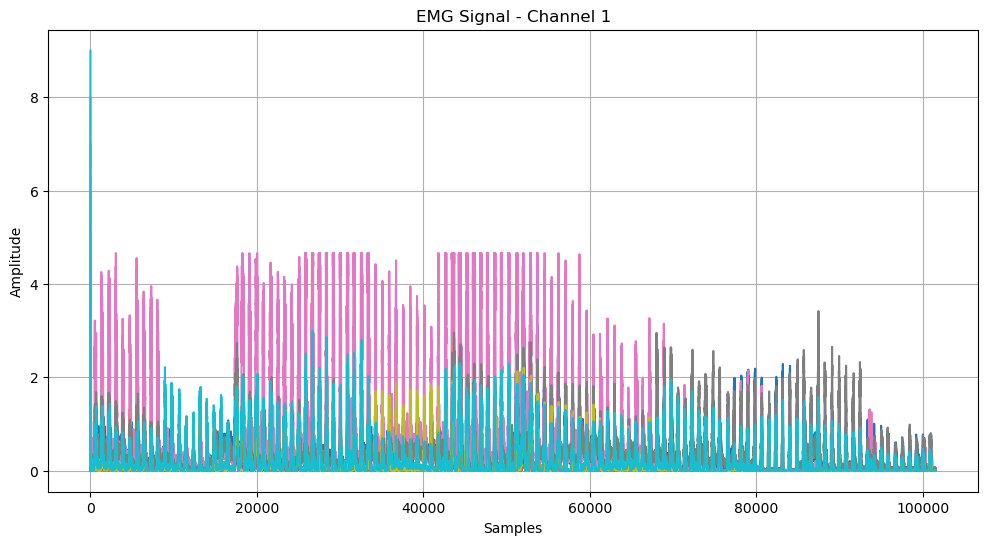

In [113]:
plt.figure(figsize=(12, 6))
plt.plot(emg_s1_ch0)
plt.title("EMG Signal - Channel 1")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [47]:
from libemg.datasets import OneSubjectMyoDataset

WINDOW_SIZE = 20
WINDOW_INCREMENT = 10 
FEATURE_SET = "HTD"

# Load in dataset
dataset = OneSubjectMyoDataset()
data = dataset.prepare_data()

60 data files fetched out of 61 files.


In [48]:
data

{'All': <libemg.data_handler.OfflineDataHandler at 0x1cd89e6a5d0>,
 'Train': <libemg.data_handler.OfflineDataHandler at 0x1cd88fd4380>,
 'Test': <libemg.data_handler.OfflineDataHandler at 0x1cd89e61820>}